In [3]:
# Import libraries
!pip install librosa
!pip install dtw
!pip install jiwer
!pip install speechbrain
!pip install whisper
import librosa
import numpy as np
from dtw import dtw
import whisper
from jiwer import wer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for whisper: filename=whisper-1.1.10-py3-none-any.whl size=41120 sha256=7bae7e7db3ce7c623e5cd991d2a7e2577229745d24e6f07beb131d5e94fee33e
  Stored in directory: /root/.cache/pip/wheels/21/65/ee/4e6672aabfa486d3341a39a04f8f87c77e5156149299b5a7d0
Successfully built whisper


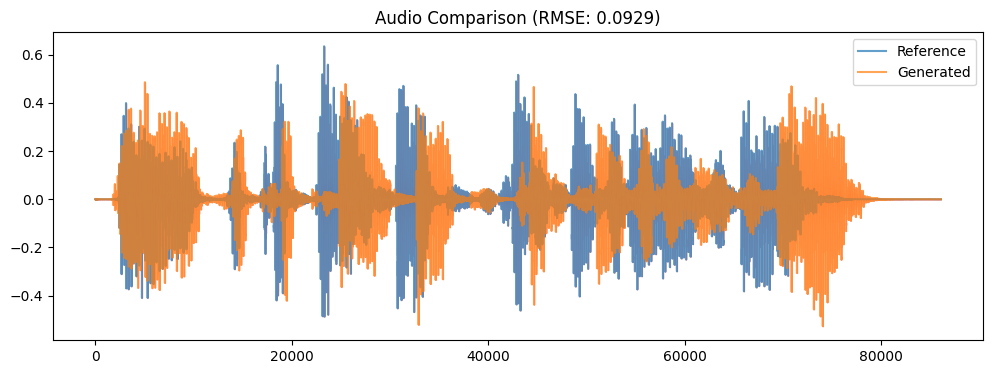

RMSE: 0.0929


In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def calculate_rmse(reference_audio, generated_audio, sr=24000):
    # Load audio if paths are provided
    if isinstance(reference_audio, str):
        reference_audio, _ = librosa.load(reference_audio, sr=sr)
    if isinstance(generated_audio, str):
        generated_audio, _ = librosa.load(generated_audio, sr=sr)

    # Convert to mono if needed
    if len(reference_audio.shape) > 1:
        reference_audio = np.mean(reference_audio, axis=0)
    if len(generated_audio.shape) > 1:
        generated_audio = np.mean(generated_audio, axis=0)

    # Trim to same length
    min_length = min(len(reference_audio), len(generated_audio))
    ref_trimmed = reference_audio[:min_length]
    gen_trimmed = generated_audio[:min_length]

    # Calculate RMSE
    rmse = np.sqrt(np.mean((ref_trimmed - gen_trimmed) ** 2))
    plt.figure(figsize=(12, 4))
    plt.plot(ref_trimmed, label='Reference', alpha=0.7)
    plt.plot(gen_trimmed, label='Generated', alpha=0.7)
    plt.fill_between(np.arange(min_length), ref_trimmed, gen_trimmed, color='red', alpha=0.3)
    plt.title(f"Audio Comparison (RMSE: {rmse:.4f})")
    plt.legend()
    plt.show()
    return rmse

rmse_score = calculate_rmse("/content/original.wav", "/content/output.wav")
print(f"RMSE: {rmse_score:.4f}")

In [28]:
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from scipy.spatial.distance import cosine
import numpy as np

# Step 3: Load the speaker encoder model
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="tmp_spkrec")

# Step 4: Helper functions

def get_speaker_embedding(audio_path):
    """Extract speaker embedding from an audio file."""
    signal, fs = torchaudio.load(audio_path)
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)  # convert to mono
    embedding = classifier.encode_batch(signal)
    embedding = embedding.squeeze(0).squeeze(0)  # <-- Fix: flatten properly
    return embedding.detach().cpu().numpy()


def calculate_cosine_similarity(emb1, emb2):
    """Calculate cosine similarity between two embeddings."""
    similarity = 1 - cosine(emb1, emb2)
    return similarity

# Step 5: Paths to your real and cloned audios
real_audio_path = "/content/original.wav"    # e.g., "real_sample.wav"
cloned_audio_path = "/content/output.wav" # e.g., "generated_sample.wav"

real_embedding = get_speaker_embedding(real_audio_path)
cloned_embedding = get_speaker_embedding(cloned_audio_path)

similarity_score = calculate_cosine_similarity(real_embedding, cloned_embedding)
print(f"🔎 Speaker Similarity Score: {similarity_score:.4f}")

# Step 8: Interpret results
if similarity_score > 0.8:
    print("✅ Very high speaker similarity!")
elif similarity_score > 0.6:
    print("⚡ Moderate similarity, may need improvement.")
else:
    print("❌ Low similarity, check voice cloning quality.")


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/tmp_spkrec/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in tmp_spkrec.
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Using symlink found at '/content/tmp_spkrec/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /content/tmp_spkrec/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Using symlink found at '/content/tmp_spkrec/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /content/tmp_spkrec/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Using symlink found at '/content/tmp_spkrec/classifier.ckpt'
DEBU

🔎 Speaker Similarity Score: 0.8753
✅ Very high speaker similarity!


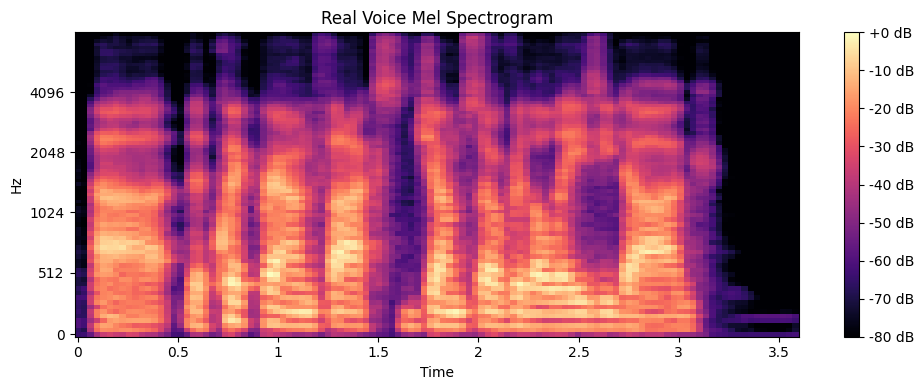

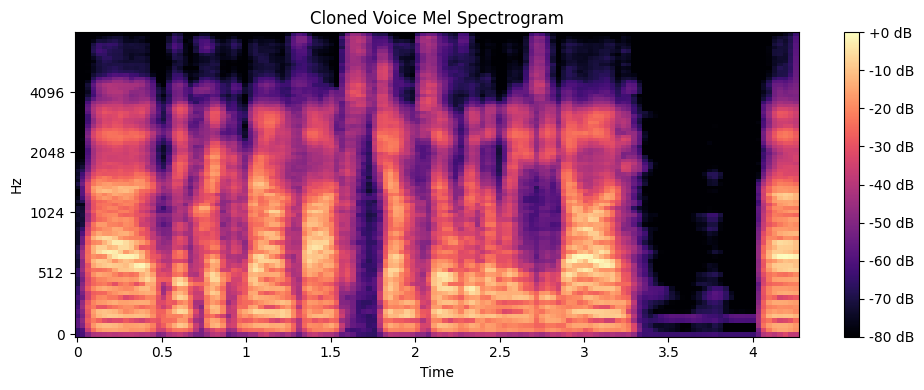

In [31]:
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

def plot_mel_spectrogram(audio_path, title):
    """Plot mel spectrogram of an audio file."""
    y, sr = librosa.load(audio_path, sr=16000)  # load at 16kHz
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example Usage
plot_mel_spectrogram("/content/original.wav", title="Real Voice Mel Spectrogram")
plot_mel_spectrogram("/content/output.wav", title="Cloned Voice Mel Spectrogram")
